In [1]:
import underworld as uw
from underworld import function as fn
from planetengine.utilities import quickShow
import math
from scipy import stats
import glucifer

In [2]:
boxHeight = 1.0
boxLength = 1.0
# Set grid resolution.
res = 128
# Set max & min temperautres
tempMin = 0.0
tempMax = 1.0

In [3]:
Ra = 1e7
eta0 = 3e4

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField       = mesh.add_variable(         nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
temperatureField    = mesh.add_variable(         nodeDofCount=1 )
temperatureDotField = mesh.add_variable(         nodeDofCount=1 )

# initialise velocity, pressure and temperatureDot field
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureField.data[:]    = 0.
temperatureDotField.data[:] = 0.

In [5]:
# Set a constant viscosity.
viscosity = 1.

# Create our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# A buoyancy function.
buoyancyFn = densityFn * z_hat

In [6]:
temperatureField.data[:] = 0.
pertStrength = 0.1
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))


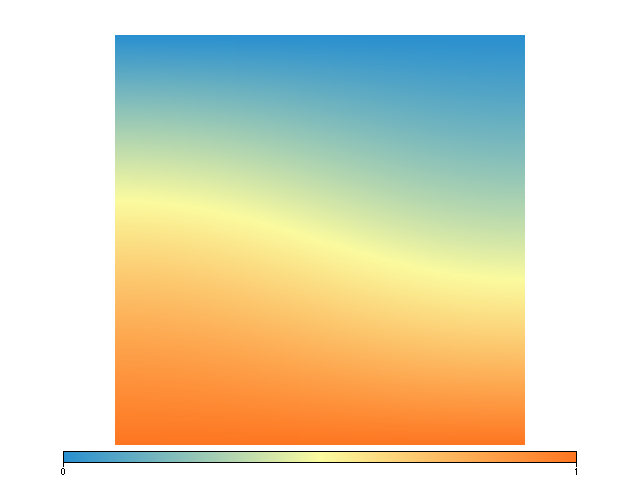

In [7]:
quickShow(temperatureField)

In [8]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

In [9]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

In [10]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity  = viscosity, 
                               fn_bodyforce  = buoyancyFn )
# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

In [11]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

In [12]:
#solver.set_inner_method('mg')
solver.set_inner_method('lu')

In [13]:
def iterate():
    solver.solve()
    advDiff.integrate(advDiff.get_max_dt())

for i in range(10):
    iterate()


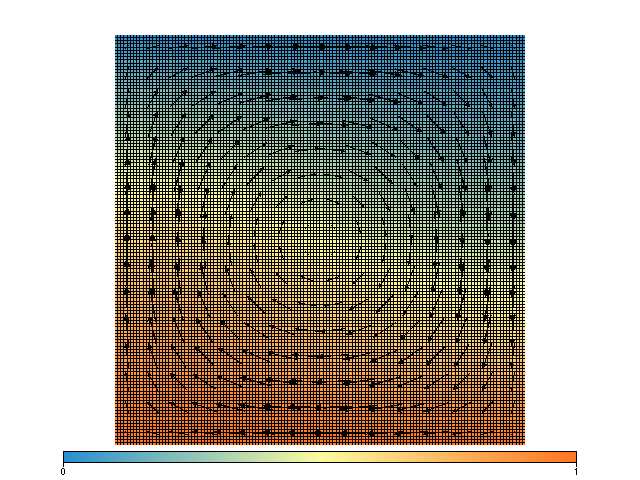

In [14]:
quickShow(mesh, temperatureField, velocityField)

In [15]:
velGrad = velocityField.fn_gradient
divFn = velGrad[0] + velGrad[3]
curlFn = velGrad[2] - velGrad[1]
allNodes = mesh.specialSets['Empty']
allNodes.invert()
nonWalls = allNodes - mesh.specialSets['AllWalls_VertexSet']

In [16]:
#stats.describe(divFn.evaluate(nonWalls))
stats.describe(divFn.evaluate(mesh))

DescribeResult(nobs=16641, minmax=(array([-1295.26967061]), array([ 1293.05988973])), mean=array([ 0.00125229]), variance=array([ 835869.74970475]), skewness=array([-0.00230503]), kurtosis=array([-1.50040056]))

In [17]:
velocityField.fn_gradient.evaluate(nonWalls)

array([[ -1.05316511e+05,   9.59590920e+01,  -9.79770372e+01,
          1.05321207e+05],
       [ -1.05186802e+05,   1.91366331e+02,  -1.61619375e+02,
          1.05223746e+05],
       [ -1.04993569e+05,   2.86260577e+02,  -2.24862063e+02,
          1.05062244e+05],
       ..., 
       [ -1.05186796e+05,   9.52916617e+01,  -1.61619366e+02,
          1.05125876e+05],
       [ -1.05316505e+05,   6.36875039e+01,  -9.79770309e+01,
          1.05287495e+05],
       [ -1.05381755e+05,   3.19411104e+01,  -3.27679089e+01,
          1.05385472e+05]])

In [18]:
stats.describe(divFn.evaluate(mesh.specialSets['AllWalls_VertexSet']))

DescribeResult(nobs=512, minmax=(array([-1293.20753599]), array([ 1293.05988973])), mean=array([-0.03677605]), variance=array([ 837156.25250576]), skewness=array([  2.30054762e-05]), kurtosis=array([-1.50013107]))

In [24]:
stats.describe(velGrad.evaluate(mesh))

DescribeResult(nobs=16641, minmax=(array([-105413.70225257,       0.        , -105290.39159155,
       -105264.21927474]), array([ 105260.66445436,  105220.71159739,       0.        ,
        105418.24027455])), mean=array([ -4.59804330e-03,   4.20477082e+04,  -4.20391786e+04,
         5.85033282e-03]), variance=array([  2.81718902e+09,   9.63046991e+08,   9.63967056e+08,
         2.81740010e+09]), skewness=array([-0.00069559,  0.37962655, -0.38126054,  0.00069445]), kurtosis=array([-0.76098432, -1.085482  , -1.08381241, -0.7609846 ]))


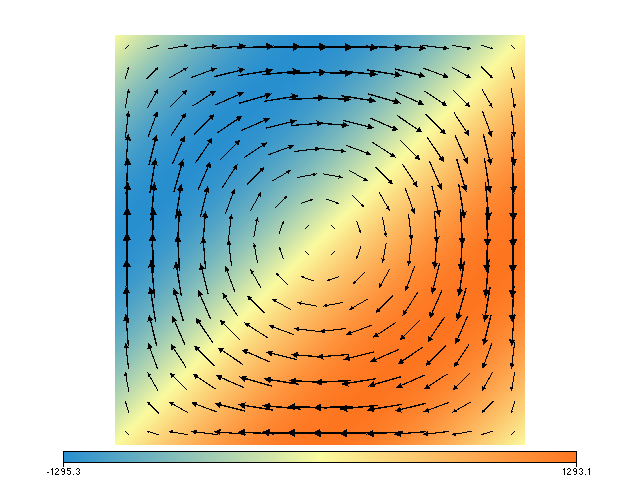

In [19]:
quickShow((mesh, divFn), velocityField)


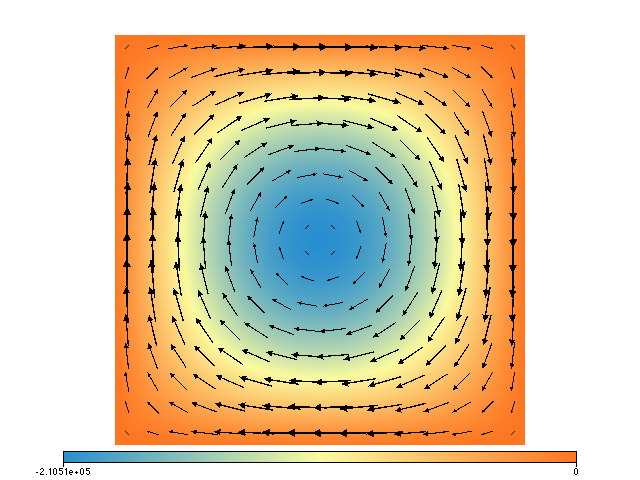

In [20]:
quickShow((mesh, curlFn), velocityField)

In [21]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(divFn, onMesh = True) )
fig.show()

TypeError: __init__() missing 1 required positional argument: 'fn'

In [ ]:
divFn.evaluate([0.51, 0.31])

In [ ]:
23.76 * 2